notebook_deniz_f_selection

1. Variance Thresholder

In [1]:
# X_train, X_test, y_train, y_test = train_test_split(data, target)
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(X_train)

# thresholder = VarianceThreshold(threshold=.5)
# data_var_th = thresholder.fit_transform(scaled_data)

Next looked at was SelectKBest and a similar alternative SelectFromModel - I model these out so that you can choose the correct k from a visual instead of using the sklearn model

notebook_deniz_feature_selection_last

Again looks at SelectKBest. Next is RFE which is very similar to SelectFromModel and again will be modeled manuallys so that visually we can decide on k and then again SelectFromModel.

notebook_sami_GBR

2. Gradient Boosting

This in addition to RandomForest will be used as the two models using in RFE and SelectFromModel analysis

In [2]:
# GBR = GradientBoostingRegressor(learning_rate= 0.1, n_estimators=1500, max_depth=2)
# GBR.fit(x_train, y_train)
# important_cols = x.columns[GBR.feature_importances_ > 0.0]
# values = GBR.feature_importances_[GBR.feature_importances_ > 0.0]

notebook_tova_features2

In [3]:
# feature_importances = sorted(zip(X_train.columns, rf.feature_importances_), reverse=True, key=lambda x: x[1])
# feature_df = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

# plt.figure(figsize=(18,6))
# plt.bar(feature_df.feature[:25], feature_df.importance[:25])
# plt.xticks(rotation=45)
# plt.title('Feature Importances')
# plt.tight_layout();

In [4]:
# train_scores = []
# f1_macro = []
# accuracy = []
# recall = []
# precision = []

# #Going to run the RFClassification on 
# for num_features in range(1,max_num_features):
#     features = list(feature_df.iloc[:num_features, 0].values) + ['SalePrice']
#     data_partial = data.loc[:, features]
#     X_train, X_test, y_train, y_test = get_binned_train_test_split(data_partial)
#     rf = RandomForestClassifier(**best_params)
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)
#     f1_macro.append(f1_score(y_test, y_pred, average='macro'))
#     accuracy.append(accuracy_score(y_test, y_pred))
#     recall.append(recall_score(y_test, y_pred, average='macro'))
#     precision.append(precision_score(y_test, y_pred, average='macro'))
#     train_scores.append(rf.score(X_train, y_train))

In [5]:
# plt.figure(figsize=(18,8))
# plt.plot(range(1, max_num_features), train_scores, label='train_score')
# plt.plot(range(1, max_num_features), f1_macro, label='f1_macro')
# plt.plot(range(1, max_num_features), accuracy, label='accuracy')
# plt.plot(range(1, max_num_features), recall, label='recall')
# plt.plot(range(1, max_num_features), precision, label='precision')
# plt.xticks(range(1, max_num_features))
# plt.legend()
# plt.xlabel('Number of features used')
# plt.ylabel('metric score %')

### Ok what now?
The tools we have are: Variance, GBR feature imporances, and RF feature importances.
We need to decide which to use and what the threshold is or what the number of features we want is.

We will do this seperately for Classification (SVM, RFC) and for Regression (lasso, ridge, and RF). 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [7]:
data = pd.read_csv('Numerical_train.csv')

In [8]:
data = data.drop([89, 524, 636, 706, 1299])

In [9]:
data.columns

Index(['Unnamed: 0', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Alley', 'LotShape', 'LandContour', 'LandSlope', 'OverallQual',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=158)

In [10]:
target = data.SalePrice

In [11]:
data, data_test, target, target_test = train_test_split(data, target, test_size=.3)

In [12]:
target_log = np.log(target)

In [13]:
target_binned = [0 if price <= 120000 else 1 if price <= 200000 else 2 for price in target]

In [14]:
data = data.drop(['SalePrice', 'Unnamed: 0'], axis=1)

#### Variance

getting variance per feature

In [15]:
thresholder = VarianceThreshold()

In [16]:
thresholder.fit(data)

VarianceThreshold(threshold=0.0)

In [17]:
feature_importances_var = sorted(zip(data.columns, thresholder.variances_), reverse=True, key=lambda x: x[1])
feature_df_var = pd.DataFrame(feature_importances_var, columns=['feature', 'importance'])

In [18]:
feature_df_var.head()

,feature,importance
0,LotArea,7.298778e+07
1,MiscVal,3.381683e+05
2,GrLivArea,2.922111e+05
3,BsmtFinSF1,2.119859e+05
4,TotalBsmtSF,2.051987e+05


In [19]:
feature_df_var.tail()

,feature,importance
151,SaleType_Oth,0.000982
152,LotConfig_FR3,0.000000
153,Exterior1st_ImStucc,0.000000
154,Exterior2nd_Other,0.000000
155,SaleType_Con,0.000000


#### GBR

Now getting feature importances from GBR

First lets decide the best parameters

In [20]:
GBR = GradientBoostingRegressor()

In [21]:
param_grid = dict(learning_rate = [1, .1, .001, .0001],
                  n_estimators = [100, 500, 1000, 1500],
                  max_depth = [1, 2, 5, 10])

In [22]:
gridsearch_gbr = GridSearchCV(estimator = GBR, param_grid = param_grid, cv=3)

In [23]:
# gridsearch_gbr.fit(data, target_log)

In [24]:
# gridsearch_gbr.best_params_

In [25]:
best_params_gbr = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}

Ok, now that we got the best parameters lets find feature importances.

In [26]:
GBR = GradientBoostingRegressor(**best_params_gbr)

In [27]:
GBR.fit(data, target_log)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
feature_importances_gbr = sorted(zip(data.columns, GBR.feature_importances_), reverse=True, key=lambda x: x[1])
feature_df_gbr = pd.DataFrame(feature_importances_gbr, columns=['feature', 'importance'])

In [29]:
feature_df_gbr.head()

,feature,importance
0,OverallQual,0.371692
1,GrLivArea,0.181406
2,GarageArea,0.061753
3,GarageFinish,0.052888
4,TotalBsmtSF,0.051261


In [30]:
feature_df_gbr.tail()

,feature,importance
151,SaleType_CWD,0.0
152,SaleType_Con,0.0
153,SaleType_ConLI,0.0
154,SaleType_ConLw,0.0
155,SaleCondition_AdjLand,0.0


#### RF

Now getting feature importances from RF

First lets decide the best parameters

In [31]:
# from deniz's GridSearchCV
best_params_rf={'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 300}

In [32]:
RF = RandomForestRegressor()

In [33]:
param_grid = dict(max_depth = [45, 50, 55],
                  min_samples_leaf = [1, 2, 3],
                  min_samples_split = [3, 4, 5],
                  n_estimators = [250, 300, 350, 400, 450])

In [34]:
gridsearch_rf = GridSearchCV(estimator = RF, param_grid = param_grid, cv=3)

In [35]:
# gridsearch_rf.fit(data, target_log)

In [36]:
# gridsearch_rf.best_params_

In [37]:
best_params_rf = {'max_depth': 35,
                  'min_samples_leaf': 2,
                  'min_samples_split': 4,
                  'n_estimators': 250}

Ok, now that we got the best parameters lets find feature importances.

In [38]:
RF = RandomForestRegressor(**best_params_rf)

In [39]:
RF.fit(data, target_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [40]:
feature_importances_rf = sorted(zip(data.columns, RF.feature_importances_), reverse=True, key=lambda x: x[1])
feature_df_rf = pd.DataFrame(feature_importances_rf, columns=['feature', 'importance'])

In [41]:
feature_df_rf.head()

,feature,importance
0,OverallQual,0.522762
1,GrLivArea,0.136608
2,GarageArea,0.052289
3,TotalBsmtSF,0.045192
4,BsmtFinSF1,0.035671


In [42]:
feature_df_rf.tail()

,feature,importance
151,SaleType_CWD,0.0
152,SaleType_Con,0.0
153,SaleType_ConLI,0.0
154,SaleType_Oth,0.0
155,SaleCondition_AdjLand,0.0


#### ok so now we have 3 lists of feature importances: variance, gbr, and rf

now lets compare then and see the overlap

In [43]:
features_compare = pd.DataFrame()

In [44]:
features_compare['var'] = feature_df_var.feature
features_compare['gbr'] = feature_df_gbr.feature
features_compare['rf'] = feature_df_rf.feature

In [45]:
features_compare.head(10)

,var,gbr,rf
0,LotArea,OverallQual,OverallQual
1,MiscVal,GrLivArea,GrLivArea
2,GrLivArea,GarageArea,GarageArea
3,BsmtFinSF1,GarageFinish,TotalBsmtSF
4,TotalBsmtSF,TotalBsmtSF,BsmtFinSF1
5,BsmtUnfSF,KitchenQual,1stFlrSF
6,2ndFlrSF,BsmtFinSF1,YearBuilt
7,1stFlrSF,1stFlrSF,2ndFlrSF
8,GarageArea,2ndFlrSF,LotArea
9,MasVnrArea,BsmtQual,MSZoning


In [46]:
features_compare_2 = features_compare.iloc[:,1:]

In [47]:
features_compare_2.head()

,gbr,rf
0,OverallQual,OverallQual
1,GrLivArea,GrLivArea
2,GarageArea,GarageArea
3,GarageFinish,TotalBsmtSF
4,TotalBsmtSF,BsmtFinSF1


In [48]:
def top_n_features(n):
    return features_compare.iloc[:n, :].stack().value_counts()

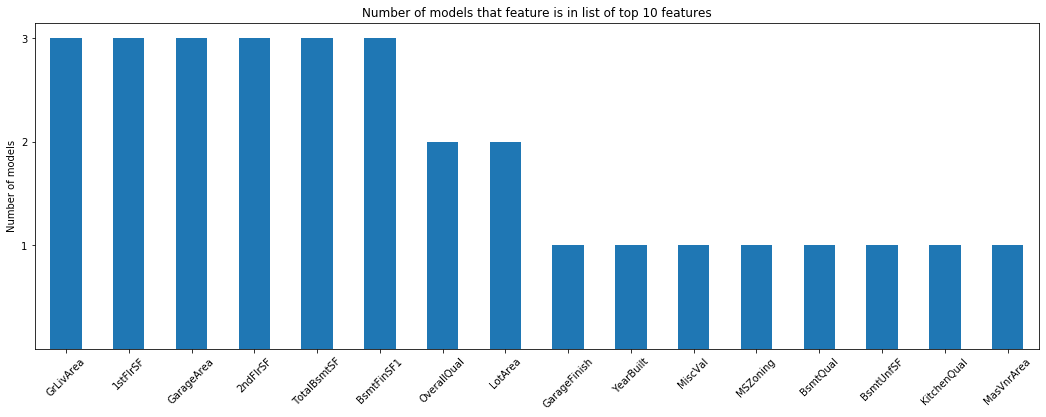

In [49]:
plt.figure(figsize=(18,6))
top_n_features(10)[:40].plot(kind='bar')
plt.title('Number of models that feature is in list of top 10 features')
plt.ylabel('Number of models')
plt.xticks(rotation=45);
plt.yticks([1,2,3]);

You can see from here the features that all, two, and at least one model thinks are the top 20 in importance

### Now for each of the models we will do some feature selection and then compare the best of each models

#### Lasso

In [50]:
max_num_features = 51

In [51]:
lasso_train_scores = pd.DataFrame()
lasso_test_scores = pd.DataFrame()

In [52]:
for name, feature_df in zip(['var', 'gbr', 'rf'], [feature_df_var, feature_df_gbr, feature_df_rf]):
    lasso_r_squared_train = []
    lasso_r_squared_test = []
    
    for num_features in range(1,max_num_features):
        features = list(feature_df.iloc[:num_features, 0].values)
        data_partial = data.loc[:, features]
        
        pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
        scores = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
        
        lasso_r_squared_train.append(scores['train_score'].mean())
        lasso_r_squared_test.append(scores['test_score'].mean())
    
    lasso_train_scores[name] = lasso_r_squared_train
    lasso_test_scores[name] = lasso_r_squared_test

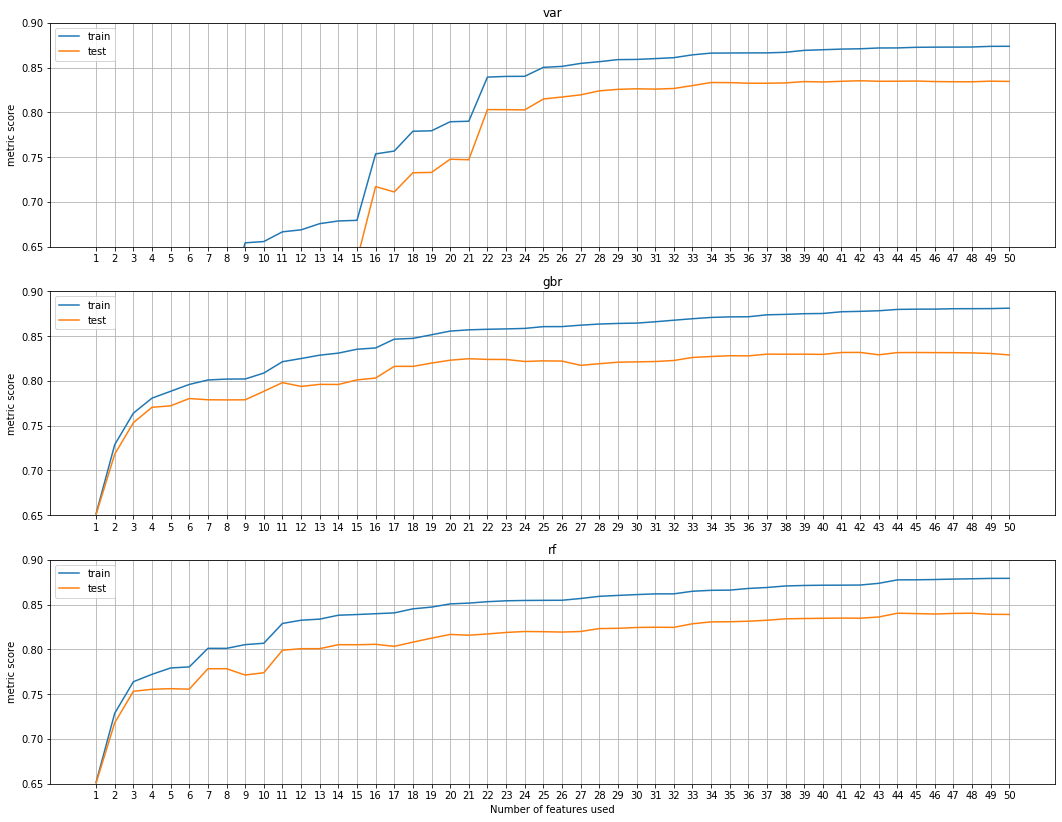

In [53]:
fig, axes = plt.subplots(3,1, figsize=(18,14))

for ax, name in zip([0,1,2], ['var', 'gbr', 'rf']):
    axes[ax].plot(range(1, max_num_features), lasso_train_scores[name], label='train')
    axes[ax].plot(range(1, max_num_features), lasso_test_scores[name], label='test')
    axes[ax].legend()
    axes[ax].set_ylabel('metric score')
    axes[ax].title.set_text(name)
    axes[ax].set_xticks(range(1, max_num_features))
    axes[ax].grid()
    axes[ax].set_ylim(.65,.9)
    
plt.xlabel('Number of features used');

In [54]:
cross_validate(pipeline_lasso, data, target_log, cv=3, scoring='r2', return_train_score=True)
print('Compare to scores on full data')
print('train score,' , scores['train_score'].mean())
print('test score,' , scores['test_score'].mean())

Compare to scores on full data
train score, 0.8794731633541328
test score, 0.8391577578940638


#### Ridge

In [55]:
max_num_features = 51

In [56]:
ridge_train_scores = pd.DataFrame()
ridge_test_scores = pd.DataFrame()

In [57]:
for name, feature_df in zip(['var', 'gbr', 'rf'], [feature_df_var, feature_df_gbr, feature_df_rf]):
    ridge_r_squared_train = []
    ridge_r_squared_test = []
    
    for num_features in range(1,max_num_features):
        features = list(feature_df.iloc[:num_features, 0].values)
        data_partial = data.loc[:, features]
        
        pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
        scores = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
        
        ridge_r_squared_train.append(scores['train_score'].mean())
        ridge_r_squared_test.append(scores['test_score'].mean())
    
    ridge_train_scores[name] = ridge_r_squared_train
    ridge_test_scores[name] = ridge_r_squared_test

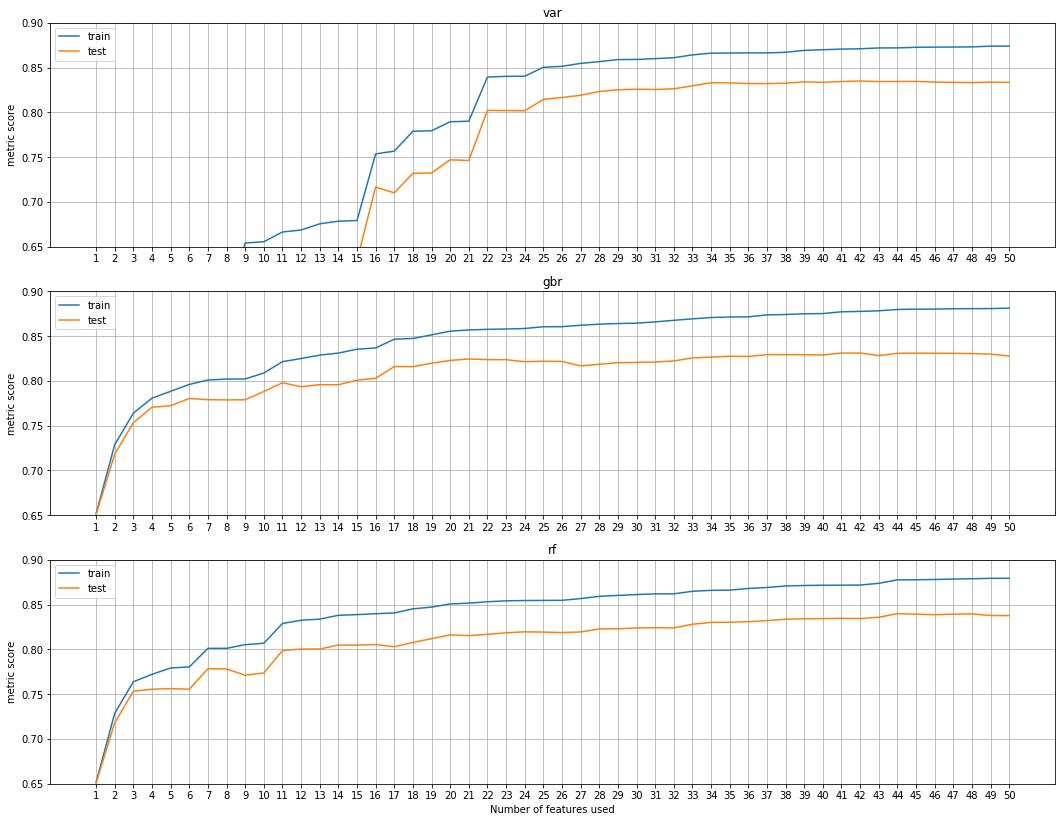

In [58]:
fig, axes = plt.subplots(3,1, figsize=(18,14))

for ax, name in zip([0,1,2], ['var', 'gbr', 'rf']):
    axes[ax].plot(range(1, max_num_features), ridge_train_scores[name], label='train')
    axes[ax].plot(range(1, max_num_features), ridge_test_scores[name], label='test')
    axes[ax].legend()
    axes[ax].set_ylabel('metric score')
    axes[ax].title.set_text(name)
    axes[ax].set_xticks(range(1, max_num_features))
    axes[ax].grid()
    axes[ax].set_ylim(.65,.9)
    
plt.xlabel('Number of features used');

In [59]:
cross_validate(pipeline_ridge, data, target_log, cv=3, scoring='r2', return_train_score=True)
print('Compare to scores on full data')
print('train score,' , scores['train_score'].mean())
print('test score,' , scores['test_score'].mean())

Compare to scores on full data
train score, 0.8795456427839631
test score, 0.8378043372067557


#### Random Forest

In [60]:
max_num_features = 31

In [61]:
rf_train_scores = pd.DataFrame()
rf_test_scores = pd.DataFrame()

In [62]:
for name, feature_df in zip(['var', 'gbr', 'rf'], [feature_df_var, feature_df_gbr, feature_df_rf]):
    rf_r_squared_train = []
    rf_r_squared_test = []
    
    for num_features in range(1,max_num_features):
        features = list(feature_df.iloc[:num_features, 0].values)
        data_partial = data.loc[:, features]
        
        rf = RandomForestRegressor(**best_params_rf)
        scores = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
        
        rf_r_squared_train.append(scores['train_score'].mean())
        rf_r_squared_test.append(scores['test_score'].mean())
    
    rf_train_scores[name] = rf_r_squared_train
    rf_test_scores[name] = rf_r_squared_test

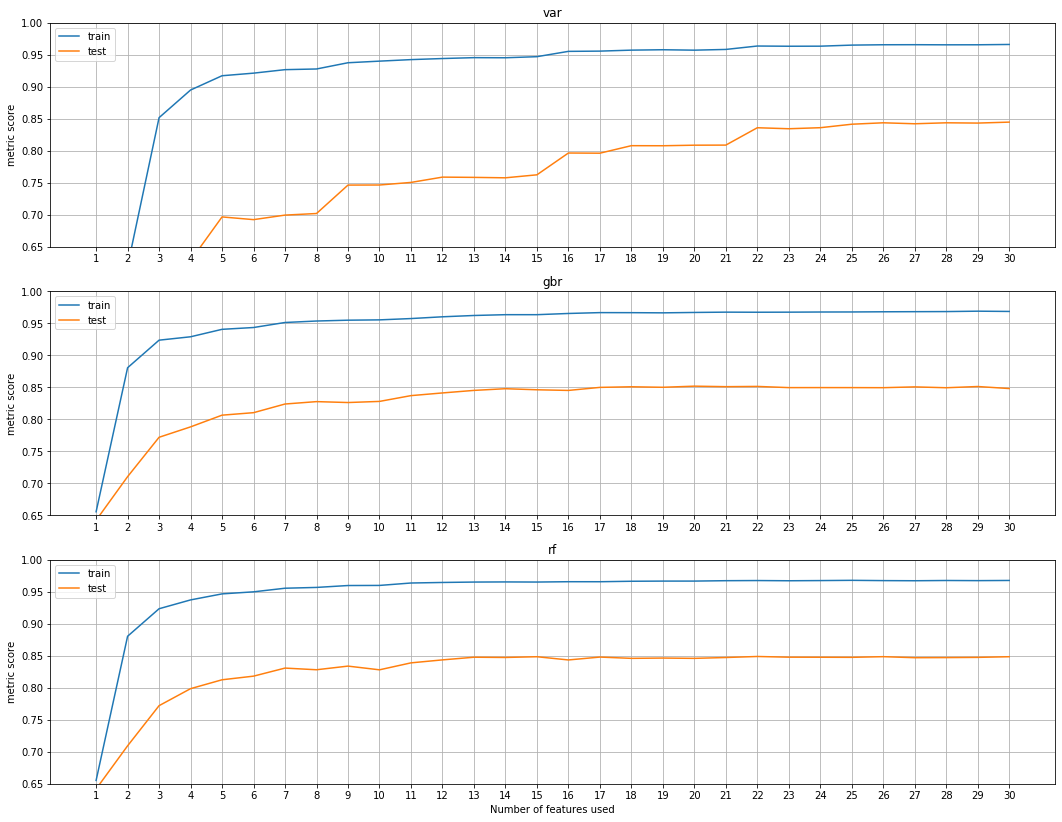

In [63]:
fig, axes = plt.subplots(3,1, figsize=(18,14))

for ax, name in zip([0,1,2], ['var', 'gbr', 'rf']):
    axes[ax].plot(range(1, max_num_features), rf_train_scores[name], label='train')
    axes[ax].plot(range(1, max_num_features), rf_test_scores[name], label='test')
    axes[ax].legend()
    axes[ax].set_ylabel('metric score')
    axes[ax].title.set_text(name)
    axes[ax].set_xticks(range(1, max_num_features))
    axes[ax].grid()
    axes[ax].set_ylim(.65,1)
    
plt.xlabel('Number of features used');

In [64]:
cross_validate(rf, data, target_log, cv=3, scoring='r2', return_train_score=True)
print('Compare to scores on full data')
print('train score,' , scores['train_score'].mean())
print('test score,' , scores['test_score'].mean())

Compare to scores on full data
train score, 0.9679546475519901
test score, 0.8487125559669648


### Comparing features

#### set of top 10

top_10 is the set of all features that falls into the top 10 features of any of the feature rating technique

In [65]:
top_10 = top_n_features(10).index

In [66]:
data_partial = data.loc[:, top_10]

In [67]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.8229843110206468
lasso test:  0.7901734295579401
ridge train:  0.8230567429484572
ridge test:  0.78917181653775
rf train:  0.9633911973508223
rf test:  0.8304401501426336


In [68]:
len(top_10)

16

In [69]:
top_10

Index(['GrLivArea', '1stFlrSF', 'GarageArea', '2ndFlrSF', 'TotalBsmtSF',
       'BsmtFinSF1', 'OverallQual', 'LotArea', 'GarageFinish', 'YearBuilt',
       'MiscVal', 'MSZoning', 'BsmtQual', 'BsmtUnfSF', 'KitchenQual',
       'MasVnrArea'],
      dtype='object')

##### For random forest these are enough to achieve optimum results.

#### set of top 20

In [70]:
top_20 = top_n_features(20).index

top_20 is the set of all features that falls into the top 20 features of any of the feature rating technique

In [71]:
data_partial = data.loc[:, top_20]

In [72]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.864950514588541
lasso test:  0.8309548268240654
ridge train:  0.8648323975897613
ridge test:  0.8305006538982131
rf train:  0.9676329189284285
rf test:  0.8452586004542558


In [73]:
len(top_20)

30

In [74]:
top_20

Index(['GrLivArea', 'BsmtFinType1', 'YearBuilt', 'GarageArea', '2ndFlrSF',
       'LotArea', 'YearRemodAdd', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF',
       'Fireplaces', 'BsmtUnfSF', 'BsmtQual', 'CentralAir', 'OverallCond',
       'LotFrontage', 'MSZoning', 'GarageCond', 'GarageFinish', 'OverallQual',
       'MasVnrArea', 'ScreenPorch', 'MiscVal', 'KitchenQual', 'MSSubClass',
       'OpenPorchSF', 'WoodDeckSF', 'GarageYrBlt', 'EnclosedPorch',
       'Neighborhood_Crawfor'],
      dtype='object')

#### set of top 30

In [75]:
top_30 = top_n_features(30).index

top_30 is the set of all features that falls into the top 30 features of any of the feature rating technique

In [76]:
data_partial = data.loc[:, top_30]

In [77]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.876945717969611
lasso test:  0.8358176457866681
ridge train:  0.876893555076585
ridge test:  0.8351669483011198
rf train:  0.9684261813287486
rf test:  0.8479765232996136


In [78]:
len(top_30)

43

#### set of top 40

In [79]:
top_40 = top_n_features(40).index

top_40 is the set of all features that falls into the top 40 features of any of the feature rating technique

In [80]:
data_partial = data.loc[:, top_40]

In [81]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.8853600179827908
lasso test:  0.8400513533266488
ridge train:  0.8854166772137139
ridge test:  0.8389185941153591
rf train:  0.969274298634106
rf test:  0.8466028852582991


In [82]:
len(top_40)

54

#### set of top 50

In [83]:
top_50 = top_n_features(50).index

top_50 is the set of all features that falls into the top 50 features of any of the feature rating technique

In [84]:
data_partial = data.loc[:, top_50]

In [85]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])
scores_lasso = cross_validate(pipeline_lasso, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=5))])
scores_ridge = cross_validate(pipeline_ridge, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)
    
rf = RandomForestRegressor(**best_params_rf)
scores_rf = cross_validate(rf, data_partial, target_log, cv=3, scoring='r2', return_train_score=True)

for model, scores in zip(['lasso', 'ridge', 'rf'], [scores_lasso, scores_ridge, scores_rf]):
        print(model, 'train: ', scores['train_score'].mean())
        print(model, 'test: ', scores['test_score'].mean())

lasso train:  0.8945796385995713
lasso test:  0.8406414946112811
ridge train:  0.8950785905294562
ridge test:  0.8395482921303979
rf train:  0.969078221172753
rf test:  0.848082126763952


In [86]:
len(top_50)

74

### Classification models

In [87]:
best_params_rfc={'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 100}

In [88]:
max_num_features = 31

In [89]:
rfc_train_scores = pd.DataFrame()
rfc_test_scores = pd.DataFrame()

In [90]:
for name, feature_df in zip(['var', 'gbr', 'rf'], [feature_df_var, feature_df_gbr, feature_df_rf]):
    rfc_r_squared_train = []
    rfc_r_squared_test = []
    
    for num_features in range(1,max_num_features):
        features = list(feature_df.iloc[:num_features, 0].values)
        data_partial = data.loc[:, features]
        
        rfc = RandomForestClassifier(**best_params_rfc)
        scores_rfc = cross_validate(rfc, data_partial, target_binned, cv=3,
                                scoring='f1_macro', return_train_score=True)
        
        rfc_r_squared_train.append(scores_rfc['train_score'].mean())
        rfc_r_squared_test.append(scores_rfc['test_score'].mean())
    
    rfc_train_scores[name] = rfc_r_squared_train
    rfc_test_scores[name] = rfc_r_squared_test

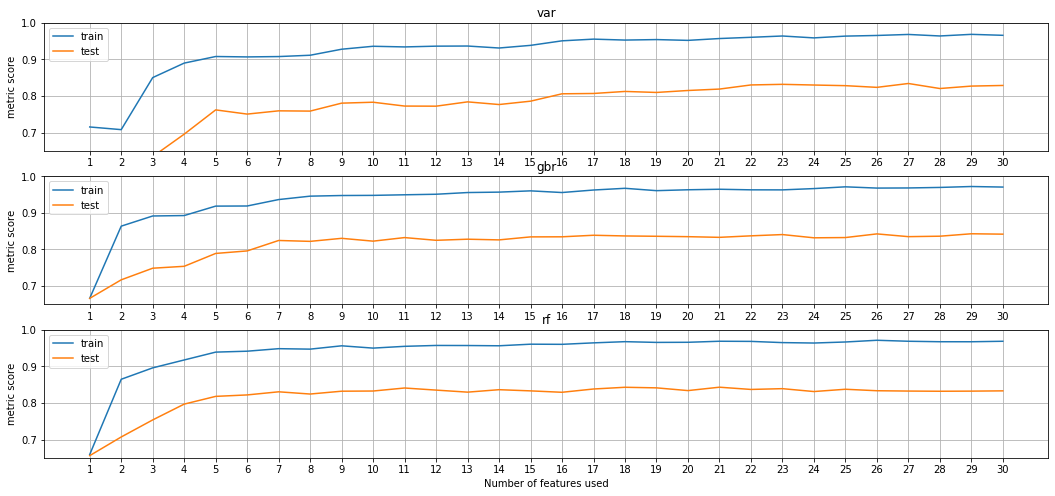

In [91]:
fig, axes = plt.subplots(3,1, figsize=(18,8))

for ax, name in zip([0,1,2], ['var', 'gbr', 'rf']):
    axes[ax].plot(range(1, max_num_features), rfc_train_scores[name], label='train')
    axes[ax].plot(range(1, max_num_features), rfc_test_scores[name], label='test')
    axes[ax].legend()
    axes[ax].set_ylabel('metric score')
    axes[ax].title.set_text(name)
    axes[ax].set_xticks(range(1, max_num_features))
    axes[ax].grid()
    axes[ax].set_ylim(.65,1)
    
plt.xlabel('Number of features used');

#### set of top 10

In [92]:
top_10 = top_n_features(10).index

top_10 is the set of all features that falls into the top 10 features of any of the feature rating technique

In [93]:
data_partial = data.loc[:, top_10]

In [94]:
rfc = RandomForestClassifier(**best_params_rfc)
scores = cross_validate(rfc, data_partial, target_binned, cv=3, scoring='f1_macro', return_train_score=True)

print(model, 'train: ', scores['train_score'].mean())
print(model, 'test: ', scores['test_score'].mean())

rf train:  0.9595323220192472
rf test:  0.8284035630947028


In [95]:
len(top_10)

16

#### set of top 20

In [96]:
top_20 = top_n_features(20).index

top_20 is the set of all features that falls into the top 20 features of any of the feature rating technique

In [97]:
data_partial = data.loc[:, top_20]

In [98]:
rfc = RandomForestClassifier(**best_params_rfc)
scores = cross_validate(rfc, data_partial, target_binned, cv=3, scoring='f1_macro', return_train_score=True)

print(model, 'train: ', scores['train_score'].mean())
print(model, 'test: ', scores['test_score'].mean())

rf train:  0.969443473398691
rf test:  0.8364009579238423


#### Scores barely improve from here so we will use the features in top_20

In [99]:
len(top_20)

30

#### set of top 30

In [100]:
top_30 = top_n_features(30).index

top_30 is the set of all features that falls into the top 30 features of any of the feature rating technique

In [101]:
data_partial = data.loc[:, top_30]

In [102]:
rfc = RandomForestClassifier(**best_params_rfc)
scores = cross_validate(rfc, data_partial, target_binned, cv=3, scoring='f1_macro', return_train_score=True)

print(model, 'train: ', scores['train_score'].mean())
print(model, 'test: ', scores['test_score'].mean())

rf train:  0.9726452200907958
rf test:  0.8373930090898621


In [103]:
len(top_30)

43

#### set of top 5

In [104]:
top_5 = top_n_features(5).index

top_5 is the set of all features that falls into the top 5 features of any of the feature rating technique

In [105]:
data_partial = data.loc[:, feature_df_rf.feature[:10]]

In [106]:
rfc = RandomForestClassifier(**best_params_rfc)
scores = cross_validate(rfc, data_partial, target_binned, cv=3, scoring='f1_macro', return_train_score=True)

print(model, 'train: ', scores['train_score'].mean())
print(model, 'test: ', scores['test_score'].mean())

rf train:  0.9532531501583783
rf test:  0.8245145765462877


In [107]:
len(top_5)

8

In [108]:
top_5

Index(['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'OverallQual',
       'GarageFinish', 'MiscVal', 'LotArea'],
      dtype='object')

# Final Testing!!


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017 entries, 657 to 370
Columns: 156 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(3), int64(153)
memory usage: 1.2 MB


In [110]:
len(target), target[:5]

(1017, 657    149000
 886    145000
 130    226000
 271    241500
 389    426000
 Name: SalePrice, dtype: int64)

In [111]:
len(target_log), target_log[:5]

(1017, 657    11.911702
 886    11.884489
 130    12.328290
 271    12.394625
 389    12.962195
 Name: SalePrice, dtype: float64)

In [112]:
len(target_binned), target_binned[:5]

(1017, [1, 1, 2, 2, 2])

In [113]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 93 to 319
Columns: 158 entries, Unnamed: 0 to SaleCondition_Partial
dtypes: float64(3), int64(155)
memory usage: 542.8 KB


In [114]:
len(target_test), target_test[:5]

(437, 93      133900
 73      144900
 1068    151400
 787     233000
 29       68500
 Name: SalePrice, dtype: int64)

In [115]:
target_test_log = np.log(target_test)

In [116]:
len(target_test_log), target_test_log[:5]

(437, 93      11.804849
 73      11.883799
 1068    11.927681
 787     12.358794
 29      11.134589
 Name: SalePrice, dtype: float64)

In [117]:
target_test_binned = [0 if price <= 120000 else 1 if price <= 200000 else 2 for price in target_test.values]

In [118]:
len(target_test_binned), target_test_binned[:5]

(437, [1, 1, 1, 2, 0])

### OK ready to go...

### Random Forest Classifier

In [119]:
best_params_rfc={'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 100}

In [120]:
param_grid = dict(max_depth = [15,20,25],
                  min_samples_leaf = [1, 2, 3],
                  min_samples_split = [6,8,10],
                  n_estimators = [50,100,150,300])

In [121]:
rfc = RandomForestClassifier(**best_params_rfc)

In [122]:
gridsearch = GridSearchCV(estimator = rfc, param_grid = param_grid, cv=3)

In [123]:
#gridsearch.fit(data.loc[:,rfc_features], target_binned)

In [125]:
#gridsearch.best_params_

In [126]:
best_params_rfc = {'max_depth': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [127]:
rfc = RandomForestClassifier(**best_params_rfc)

In [128]:
rfc_features = ['GrLivArea', 'OverallQual', 'GarageArea', 'BsmtUnfSF', 'KitchenQual',
               'MiscVal', '2ndFlrSF', 'LotArea', 'GarageFinish', '1stFlrSF',
               'TotalBsmtSF']

In [129]:
rfc.fit(data.loc[:,rfc_features], target_binned)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
rfc.score(data.loc[:,rfc_features], target_binned)

0.9488692232055064

In [131]:
rfc.score(data_test.loc[:,rfc_features], target_test_binned)

0.8192219679633868

### Random Forest Regressor

In [132]:
best_params_rf = {'max_depth': 35,
                  'min_samples_leaf': 2,
                  'min_samples_split': 4,
                  'n_estimators': 250}

In [133]:
param_grid = dict(max_depth = [30,35,40],
                  min_samples_leaf = [1, 2, 3],
                  min_samples_split = [2,4,6],
                  n_estimators = [200, 250, 300, 350])

In [134]:
rf = RandomForestRegressor(**best_params_rf)

In [135]:
gridsearch = GridSearchCV(estimator = rf, param_grid = param_grid, cv=3)

In [136]:
#gridsearch.fit(data.loc[:,rf_features], target_log)

In [137]:
#best_params_rf = gridsearch.best_params_

In [138]:
best_params_rf = {'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [139]:
rf = RandomForestRegressor(**best_params_rf)

In [140]:
rf_features = ['GrLivArea', '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1',
               'OverallQual', '2ndFlrSF', 'LotArea', 'YearBuilt', 'BsmtUnfSF',
               'MasVnrArea', 'BsmtQual', 'OverallCond', 'MiscVal', 'KitchenQual',
               'GarageFinish']

In [141]:
rf.fit(data.loc[:,rf_features], target_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [142]:
rf.score(data.loc[:,rf_features], target_log)

0.9798976717794246

In [143]:
rf.score(data_test.loc[:,rf_features], target_test_log)

0.8759449493714907

### Lasso

In [144]:
lr_features = ['BsmtFinType1', 'LotArea', 'YearRemodAdd', 'GrLivArea', '2ndFlrSF',
       '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1',
       'OpenPorchSF', 'Fireplaces', 'MSZoning', 'LotFrontage', 'OverallQual',
       'OverallCond', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'GarageFinish',
       'Neighborhood_Crawfor', 'EnclosedPorch', 'WoodDeckSF', 'MSSubClass',
       'GarageYrBlt', 'ScreenPorch', 'MiscVal', 'KitchenQual', 'MasVnrArea']

In [145]:
param_grid = dict(alpha=[.0005, .001, .005, .01, .05, .1, 1])

In [146]:
gridsearch = GridSearchCV(estimator = Lasso(normalize=True), param_grid = param_grid, cv=3)

In [147]:
gridsearch.fit(data.loc[:,lr_features], target_log)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [148]:
#gridsearch.best_params_

In [149]:
best_params_lasso = {'alpha': 0.0005}

In [150]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])

In [151]:
pipeline_lasso.fit(data.loc[:,lr_features], target_log)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [152]:
pipeline_lasso.score(data.loc[:,lr_features], target_log)

0.8598122776846922

In [153]:
pipeline_lasso.score(data_test.loc[:,lr_features], target_test_log)

0.8900883966179274

### Ridge

In [154]:
lr_features = ['BsmtFinType1', 'LotArea', 'YearRemodAdd', 'GrLivArea', '2ndFlrSF',
       '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1',
       'OpenPorchSF', 'Fireplaces', 'MSZoning', 'LotFrontage', 'OverallQual',
       'OverallCond', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'GarageFinish',
       'Neighborhood_Crawfor', 'EnclosedPorch', 'WoodDeckSF', 'MSSubClass',
       'GarageYrBlt', 'ScreenPorch', 'MiscVal', 'KitchenQual', 'MasVnrArea']

In [155]:
param_grid = dict(alpha=[.01, .05, .1, .5, 1, 2])

In [156]:
gridsearch = GridSearchCV(estimator = Ridge(normalize=True), param_grid = param_grid, cv=3)

In [157]:
gridsearch.fit(data.loc[:,lr_features], target_log)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=True, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [158]:
gridsearch.best_params_

{'alpha': 0.05}

In [159]:
best_params_ridge = {'alpha': 0.05}

In [160]:
pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=.05))])

In [161]:
pipeline_ridge.fit(data.loc[:,lr_features], target_log)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 Ridge(alpha=0.05, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [162]:
pipeline_ridge.score(data.loc[:,lr_features], target_log)

0.8600243934239843

In [163]:
pipeline_ridge.score(data_test.loc[:,lr_features], target_test_log)

0.8871240549358711